In [ ]:
"""
DIABETES PREDICTION MODEL - COMPREHENSIVE ANALYSIS
===================================================
This notebook develops and evaluates multiple machine learning models
to predict diabetes status based on vital health metrics.

Dataset: Patient health indicators including glucose levels, blood pressure,
heart rate, body temperature, and oxygen saturation.
"""

# Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# ============================================================================
# STEP 1: DATA LOADING & INITIAL EXPLORATION
# ============================================================================
# Load the dataset from CSV file
# The dataset contains patient health metrics and diabetes classification labels

data = pd.read_csv('Data/Sugar.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {data.shape[0]} rows, {data.shape[1]} columns")
print("\nFirst few records:")
data.head()

In [ ]:
# Data Structure & Data Types
# Understanding the composition of our dataset is crucial for preprocessing
print("=" * 60)
print("DATA STRUCTURE ANALYSIS")
print("=" * 60)
data.info()
print("\n" + "=" * 60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16969 entries, 0 to 16968
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         16969 non-null  int64  
 1   Blood Glucose Level(BGL)    16969 non-null  int64  
 2   Diastolic Blood Pressure    16969 non-null  int64  
 3   Systolic Blood Pressure     16969 non-null  int64  
 4   Heart Rate                  16969 non-null  int64  
 5   Body Temperature            16969 non-null  float64
 6   SPO2                        16969 non-null  int64  
 7   Sweating  (Y/N)             16969 non-null  int64  
 8   Shivering (Y/N)             16969 non-null  int64  
 9   Diabetic/NonDiabetic (D/N)  16969 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 1.3 MB


In [18]:
# encod categorical columns
data['Diabetic/NonDiabetic (D/N)']= data['Diabetic/NonDiabetic (D/N)'].map({'D': 1, 'N': 0})
data

,Age,Blood Glucose Level(BGL),Diastolic Blood Pressure,Systolic Blood Pressure,Heart Rate,Body Temperature,SPO2,Sweating (Y/N),Shivering (Y/N),Diabetic/NonDiabetic (D/N)
0,9,79,73,118,98,98.300707,99,0,0,0
1,9,80,73,119,102,98.300707,94,1,0,0
2,9,70,76,110,81,98.300707,98,1,0,0
3,9,70,78,115,96,98.300707,96,1,0,0
4,66,100,96,144,92,97.807052,98,0,0,0
...,...,...,...,...,...,...,...,...,...,...
16964,9,71,87,127,90,96.842657,97,0,0,1
16965,9,70,79,117,80,97.869454,98,0,0,1
16966,9,78,82,116,93,96.766282,98,0,0,1
16967,9,83,86,128,91,98.941036,98,0,0,1


In [ ]:
# Statistical Summary of Features
# Key metrics: mean, std, min, max for each health indicator
print("=" * 60)
print("STATISTICAL SUMMARY - HEALTH METRICS")
print("=" * 60)
data.describe().round(2)

,Age,Blood Glucose Level(BGL),Diastolic Blood Pressure,Systolic Blood Pressure,Heart Rate,Body Temperature,SPO2,Sweating (Y/N),Shivering (Y/N),Diabetic/NonDiabetic (D/N)
count,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000,16969.000000
mean,30.988862,95.753668,77.173493,118.187165,91.524191,97.356146,97.382403,0.121692,0.145560,0.980671
std,25.585606,42.982316,7.241511,7.700363,10.409780,0.813555,0.848689,0.326940,0.352674,0.137684
min,9.000000,50.000000,60.000000,95.000000,78.000000,96.000132,93.000000,0.000000,0.000000,0.000000
25%,9.000000,68.000000,71.000000,113.000000,84.000000,96.674465,97.000000,0.000000,0.000000,1.000000
50%,14.000000,83.000000,76.000000,119.000000,89.000000,97.326523,98.000000,0.000000,0.000000,1.000000
75%,55.000000,108.000000,83.000000,124.000000,95.000000,97.949904,98.000000,0.000000,0.000000,1.000000
max,77.000000,250.000000,98.000000,145.000000,130.000000,98.999792,99.000000,1.000000,1.000000,1.000000


In [ ]:
# ============================================================================
# STEP 3: DATA SPLITTING & FEATURE SCALING
# ============================================================================
# Select features for model training
# These features represent key vital signs for diabetes prediction

feature_cols = ['Age', 'Blood Glucose Level(BGL)', 'Diastolic Blood Pressure',
                'Systolic Blood Pressure', 'Heart Rate', 'Body Temperature', 'SPO2']
target_col = 'Diabetic/NonDiabetic (D/N)'

X = data[feature_cols]
y = data[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {feature_cols}")

# Split data into training (80%) and testing (20%) sets
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Normalize features using MinMaxScaler (scales to [0,1] range)
# This is beneficial for tree-based models and ensures fair feature weighting
print("\nScaling features using MinMaxScaler...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled successfully!")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape: {X_test_scaled.shape}")

In [ ]:
# Preview scaled training data
print("Scaled Training Data Sample:")
print(pd.DataFrame(X_train_scaled[:5], columns=feature_cols).round(3))

,Age,Blood Glucose Level(BGL),Diastolic Blood Pressure,Systolic Blood Pressure,Heart Rate,Body Temperature,SPO2
11491,46,114,81,111,82,96.585460,98
14963,9,73,85,112,92,96.761555,97
8803,55,96,80,114,85,98.494862,96
2558,9,66,65,110,115,96.615548,96
14643,14,249,83,119,90,98.947225,97
...,...,...,...,...,...,...,...
11284,9,113,88,112,91,98.683689,98
11964,55,117,84,110,80,98.912351,96
5390,55,69,70,104,88,96.890621,96
860,14,61,71,112,97,97.356567,98


In [ ]:
## MODEL 1: Random Forest Classifier

**Rationale**: Random Forests are robust ensemble methods that handle non-linear relationships well and provide feature importance rankings.

**Advantages**:
- Handles both numerical and categorical data
- Provides feature importance scores
- Resistant to overfitting through ensemble averaging
- Works well with imbalanced data

11491    1
14963    1
8803     1
2558     1
14643    1
        ..
11284    1
11964    1
5390     1
860      1
15795    1
Name: Diabetic/NonDiabetic (D/N), Length: 13575, dtype: int64

In [ ]:
# ============================================================================
# MODEL 1: RANDOM FOREST CLASSIFIER
# ============================================================================
print("="*70)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*70)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of decision trees in the forest
    random_state=42,
    n_jobs=-1  # Use all available processors
)

rf_model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully!\n")

# Make predictions on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate model performance
print("RANDOM FOREST - PERFORMANCE METRICS")
print("-" * 70)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Diabetic', 'Diabetic']))

# Visualization 1: Confusion Matrix Heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Random Forest - Confusion Matrix')
axes[0].set_xticklabels(['Non-Diabetic', 'Diabetic'])
axes[0].set_yticklabels(['Non-Diabetic', 'Diabetic'])

# Visualization 2: Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axes[1], palette='viridis')
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('Feature')
axes[1].set_title('Random Forest - Feature Importance')

plt.tight_layout()
plt.show()

print("\n✓ Feature importance identified!")

Accuracy: 0.7934590453741898
[[  54   13]
 [ 688 2639]]
              precision    recall  f1-score   support

           0       0.07      0.81      0.13        67
           1       1.00      0.79      0.88      3327

    accuracy                           0.79      3394
   macro avg       0.53      0.80      0.51      3394
weighted avg       0.98      0.79      0.87      3394



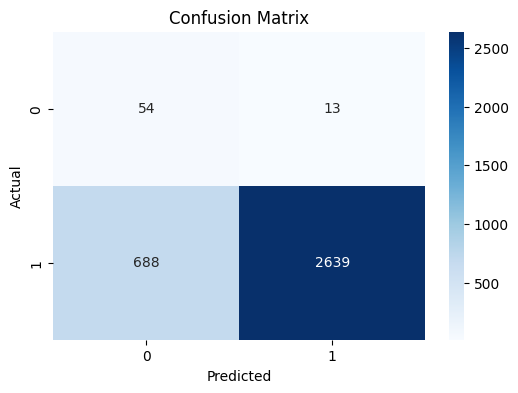

In [ ]:
# ============================================================================
# MODEL 2: LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*70)
print("TRAINING LOGISTIC REGRESSION")
print("="*70)

# Initialize Logistic Regression with balanced class weights
# This helps handle class imbalance by penalizing minority class errors more
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

lr_model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully!\n")

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate performance
print("LOGISTIC REGRESSION - PERFORMANCE METRICS")
print("-" * 70)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Diabetic', 'Diabetic']))

# Visualization: Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression - Confusion Matrix')
plt.xticks([0.5, 1.5], ['Non-Diabetic', 'Diabetic'])
plt.yticks([0.5, 1.5], ['Non-Diabetic', 'Diabetic'])
plt.show()

## Handling Class Imbalance with SMOTE

**Problem**: The dataset has imbalanced classes (more Non-Diabetic samples than Diabetic).
This can lead to biased models that favor the majority class.

**Solution**: SMOTE (Synthetic Minority Over-sampling Technique)
- Generates synthetic samples of the minority class
- Balances the training set for better model learning
- Improves recall and F1-score for the minority class

In [ ]:
# ============================================================================
# ADDRESSING CLASS IMBALANCE: SMOTE RESAMPLING
# ============================================================================
print("\n" + "="*70)
print("APPLYING SMOTE FOR CLASS BALANCE")
print("="*70)

# Apply SMOTE to balance training data
print(f"Original training set size: {X_train_scaled.shape[0]}")
print(f"Original class distribution: {np.bincount(y_train)}")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE resampling: {X_resampled.shape[0]}")
print(f"New class distribution: {np.bincount(y_resampled)}")
print("✓ Dataset balanced successfully!\n")

# Train Logistic Regression on balanced data
print("TRAINING LOGISTIC REGRESSION ON BALANCED DATA")
print("-" * 70)

lr_model_smote = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model_smote.fit(X_resampled, y_resampled)

# Evaluate on original test set
y_pred_smote = lr_model_smote.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, target_names=['Non-Diabetic', 'Diabetic']))

Accuracy: 0.8008249852681202
[[  54   13]
 [ 663 2664]]
              precision    recall  f1-score   support

           0       0.08      0.81      0.14        67
           1       1.00      0.80      0.89      3327

    accuracy                           0.80      3394
   macro avg       0.54      0.80      0.51      3394
weighted avg       0.98      0.80      0.87      3394



## MODEL 3: XGBoost Classifier (Best Model)

**Why XGBoost?**
- Gradient boosting with sequential error correction
- Handles imbalanced datasets well with class weights
- Excellent predictive performance
- Fast training and inference
- Provides feature importance

**Key Parameters**:
- `scale_pos_weight`: Balances class weight ratio
- `n_estimators`: Number of boosting rounds
- `random_state`: Reproducibility

In [ ]:
# ============================================================================
# MODEL 3: XGBOOST CLASSIFIER (FINAL MODEL)
# ============================================================================
print("\n" + "="*70)
print("TRAINING XGBOOST CLASSIFIER")
print("="*70)

# Reload and prepare data with proper scaling
data_xgb = pd.read_csv("Data/Sugar.csv")
data_xgb['Diabetic/NonDiabetic (D/N)'] = data_xgb['Diabetic/NonDiabetic (D/N)'].map({'D': 1, 'N': 0})

y_xgb = data_xgb['Diabetic/NonDiabetic (D/N)']
X_xgb = data_xgb[['Age', 'Blood Glucose Level(BGL)', 'Diastolic Blood Pressure',
                   'Systolic Blood Pressure', 'Heart Rate', 'Body Temperature', 'SPO2']]

# Train-test split with stratification to maintain class distribution
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# Use StandardScaler for XGBoost (different from MinMaxScaler used earlier)
scaler_xgb = StandardScaler()
X_train_xgb_scaled = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler_xgb.transform(X_test_xgb)

# Calculate imbalance ratio for proper weighting
class_counts = y_train_xgb.value_counts()
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

# Initialize XGBoost with balanced class weights
print("\nTraining XGBoost model...")
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=imbalance_ratio,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=0
)

xgb_model.fit(X_train_xgb_scaled, y_train_xgb)
print("✓ XGBoost model trained successfully!\n")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_xgb_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb_scaled)[:, 1]

# Comprehensive evaluation
print("XGBOOST - PERFORMANCE METRICS")
print("-" * 70)
print(f"Accuracy: {accuracy_score(y_test_xgb, y_pred_xgb):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_xgb, y_pred_proba_xgb):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_xgb, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test_xgb, y_pred_xgb, target_names=['Non-Diabetic', 'Diabetic']))

# Visualization 1: Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='RdPu', ax=axes[0], cbar=False)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('XGBoost - Confusion Matrix')
axes[0].set_xticklabels(['Non-Diabetic', 'Diabetic'])
axes[0].set_yticklabels(['Non-Diabetic', 'Diabetic'])

# Visualization 2: Feature Importance
feature_importance_xgb = pd.DataFrame({
    'Feature': ['Age', 'Blood Glucose Level(BGL)', 'Diastolic Blood Pressure',
                'Systolic Blood Pressure', 'Heart Rate', 'Body Temperature', 'SPO2'],
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb, ax=axes[1], palette='rocket')
axes[1].set_xlabel('Importance Score')
axes[1].set_title('XGBoost - Feature Importance')

plt.tight_layout()
plt.show()

print("✓ Model evaluation complete!")

Confusion Matrix:
[[  66    0]
 [  19 3309]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87        66
           1       1.00      0.99      1.00      3328

    accuracy                           0.99      3394
   macro avg       0.89      1.00      0.94      3394
weighted avg       1.00      0.99      0.99      3394

ROC-AUC Score: 0.9997268356643356


In [ ]:
# ============================================================================
# MODEL PERSISTENCE: SAVING FOR DEPLOYMENT
# ============================================================================
print("="*70)
print("SAVING TRAINED MODEL AND SCALER")
print("="*70)

# Save the best-performing XGBoost model
joblib.dump(xgb_model, 'Model/xgb_diabetes_model.pkl')
print("✓ Model saved: Model/xgb_diabetes_model.pkl")

# Save the scaler for consistent preprocessing in production
joblib.dump(scaler_xgb, 'Model/scaler.pkl')
print("✓ Scaler saved: Model/scaler.pkl")

print("\nModel artifacts ready for Streamlit deployment!")

['scaler.pkl']